In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import datetime as dt
import yfinance as yf
import statsmodels.api as sm
from scipy import stats
from scipy.stats import genpareto, t as t_dist
from statsmodels.tsa.ar_model import AutoReg

from risk_metrics_fns import *
import warnings
warnings.filterwarnings('ignore', category=FutureWarning)


In [117]:
# Useful when editing/updating risk_metrics_fns.py - run after editing to reload
%load_ext autoreload
%autoreload 2
from risk_metrics_fns import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


*Preprocessing:* download data, calculate returns, log returns, compute unsmoothed non-correlated returns, fit student-t to interior

In [118]:
end = datetime.now()
start = end - timedelta(days=365*2)
btc = yf.download('BTC-USD', start = start, end = end)
btc_df = pd.DataFrame(btc)

if isinstance(btc_df.columns, pd.MultiIndex):
    btc_df.columns = btc_df.columns.map(lambda col: col[0])
    btc_df['Date'] = pd.to_datetime(btc_df.index)
btc_df.set_index(btc_df.index, inplace=True)
btc_df['Returns'] = btc_df['Close'].pct_change()
btc_df['Logreturn'] = np.log(btc_df['Close'] / btc_df['Close'].shift(1))
S0 = 1000000


[*********************100%***********************]  1 of 1 completed


Run cell below for full risk monitor


Semi-Parametric Distribution:
Body (5%-95%):    Student-t (df=3.56)
Lower tail (<5%): GPD (ξ=-0.4240, β=0.0231)
Upper tail (>95%): GPD (ξ=0.0702, β=0.0161)

Thresholds:
  Lower: -0.034741
  Upper: 0.038852

Composite Distribution Goodness of Fit:
Mean Absolute Error:      0.000797
Root Mean Square Error:   0.001120
R-squared:                0.997285

Model Specification:
  Body (5%-95%):    Student-t (df=3.56)
  Lower tail (<5%): GPD (ξ=-0.4240)
  Upper tail (>95%): GPD (ξ=0.0702)


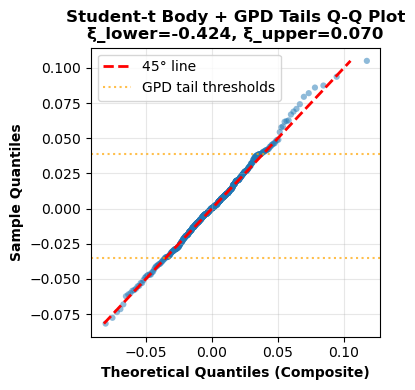


OPTIMAL ALLOCATION SUMMARY
Horizon:              1 days
Initial Capital:      $1,000,000.00
Portfolio CVaR Target (max loss):      2.0% ($20,000.00)
HODL CVaR Loss: $50,355.07
Optimal Weight w' (portfolio = w'*BTC + (1-w')*cash):       39.72% risky / 60.28% cash


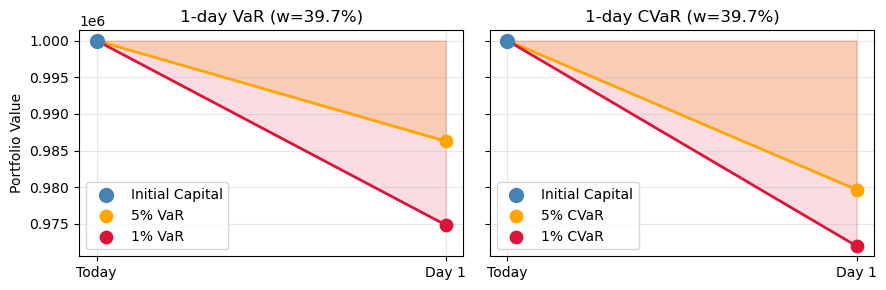


OPTIMAL ALLOCATION SUMMARY
Horizon:              7 days
Initial Capital:      $1,000,000.00
Portfolio CVaR Target (max loss):      5.0% ($50,000.00)
HODL CVaR Loss: $108,644.64
Optimal Weight w' (portfolio = w'*BTC + (1-w')*cash):       46.02% risky / 53.98% cash


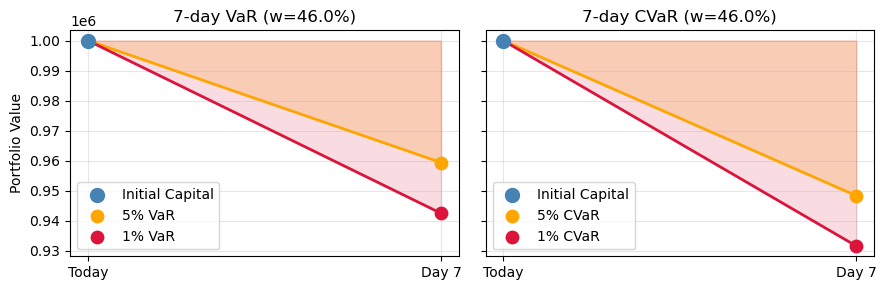


OPTIMAL ALLOCATION SUMMARY
Horizon:              30 days
Initial Capital:      $1,000,000.00
Portfolio CVaR Target (max loss):      10.0% ($100,000.00)
HODL CVaR Loss: $198,434.86
Optimal Weight w' (portfolio = w'*BTC + (1-w')*cash):       50.39% risky / 49.61% cash


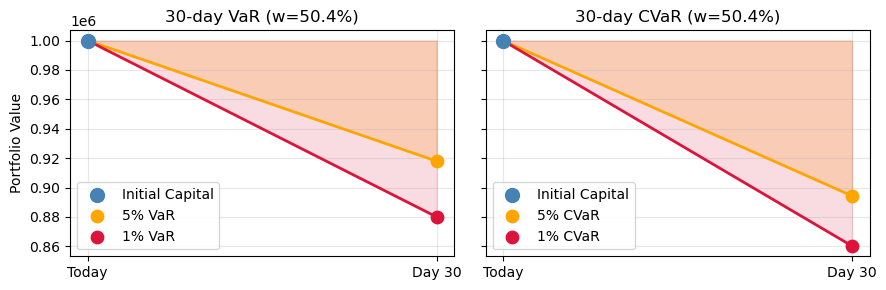

In [119]:
'''Removing 1d autocorr, unsmoothing returns, fitting student-t to interior'''
btc_returns_unsmoothed, ar_model, ar_coef, ar_const = remove_autocorrelation(btc_df['Logreturn'].iloc[1:])
df_t_unsm, loc_t_unsm, scale_t_unsm = stats.t.fit(btc_returns_unsmoothed)

'''Fit GPD to tails, compute summary statistics'''
evt_results = fit_gpd_tails(btc_returns_unsmoothed.values, threshold_quantile=0.95)
qq_statssum_composite(btc_returns_unsmoothed, evt_results)

'''QQ-plot to ensure that the GPD fit is good - pay special attention to left tail (losses)'''
complete_qq_plot(btc_returns_unsmoothed, evt_results)

optim_weights(0.02, evt_student_t_composite_rvs, S0, evt_results, df_t_unsm, loc_t_unsm, scale_t_unsm, n_paths=10000, horizon=1)
optim_weights(0.05, evt_student_t_composite_rvs, S0, evt_results, df_t_unsm, loc_t_unsm, scale_t_unsm, n_paths=10000, horizon=7)
optim_weights(0.1, evt_student_t_composite_rvs, S0, evt_results, df_t_unsm, loc_t_unsm, scale_t_unsm, n_paths=10000, horizon=30)
